## homework no: hw7
## Your name:  仙洞田咲          student ID: 1100452
### When you use code, either from another student or an outside source, you should cite it. Tell me where the code comes from. 
#### (  v )  1. I totally write by myself (都自己寫)
#### (  ) 2. other students (參考同學,註明姓名學號):   name and student id 　
#### (  ) 3. outside source (參考外部資料網站), where:
### If you choose 2 or 3, please tell me the degree of copy. (如果選2,3, 請勾選copy程度)
#### () < 25%      (  )  25%..50%     (   ) 50%..75%        (    ) > 75%
### Give me grade (期望分數): 80
### Reasons (理由): 都是有自己按照上課中教授教來完成的程式，並完全符合應有的output。
## Note that (留意底下檔案命名規格)
The filename is like this hw4_1071234.ipynb, all lower case letters, and no prefix 's' to your student ID. If homework contains only one notebook file, just upload ipynb file, do not compress ipynb file. 

If your homework contains multiple files, compress them and upload. The compressed filename should be like this hw4_1071234.zip.

## 說明與心得 explain your code briefly, tell me something, and share your experience.

這次作業中，我們將使用遷移學習來訓練一個能分類fruit-360數據集的模型。步驟如下：
從Kaggle下載fruit-360數據集，使用fruits-360_dataset文件夾中的圖片（大小為100x100，共131類）。
使用PyTorch加載預訓練的MobileNetV3 Small模型，並設置其權重。
使用模型的transform函數對數據進行轉換。
只訓練features.11之後的層，凍結之前的層。
輸出模型各參數是否需要訓練的狀態。
從訓練文件夾中生成訓練集和驗證集，並設置數據加載器。
同樣從測試文件夾生成測試集並設置數據加載器。
訓練5個周期（Epochs），並在每個周期後顯示訓練和驗證的準確率及損失。
訓練完成後，使用測試數據集評估模型，並顯示最終的準確率和損失。

這是因為是需要訓練圖像，計算需求較高，在文書型電腦上運行非常耗時，每個 epoch 的訓練和驗證需要數小時、在Colab上也嘗試過了，但無法讀取train和test數據集，出現錯誤。此外，也嘗試在jupyter notebook上添加虛擬GPU，但也未成功。儘管如此，嘗試了多次，但最終還是沒能趕上時間。

In [2]:
import random
import os
import numpy as np
import torch
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
seed = 7
random.seed(seed) # for python
np.random.seed(seed) # for NumPy, Pandas
torch.manual_seed(seed) # for PyTorch, both CPU and CUDA
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=100)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dir = 'C://Users//sakis//2024Python//fruits-360_dataset' 

weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights)
transform = weights.transforms()

num_ftrs = model.classifier[3].in_features
num_labels = 131
model.classifier[3] = nn.Linear(num_ftrs, num_labels)
model.to(device)
print(model)
print(transform)

#step3
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'features.11' in name or 'features.12' in name or 'classifier' in name:
        param.requires_grad = True
for name, param in model.named_parameters():
    print(name, param.requires_grad)
      
# Step 4

train_dataset = datasets.ImageFolder(root=f'{data_dir}/fruits-360/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/fruits-360/Test', transform=transform)
train_indices, val_indices = train_test_split(range(len(train_dataset)), train_size=0.8, random_state=42)
train_set = torch.utils.data.Subset(train_dataset, train_indices)
val_set = torch.utils.data.Subset(train_dataset, val_indices)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)

learning_rate = 0.07
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# 訓練の実施
num_epochs = 5
hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 
        
        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        
    train_acc = correct / len(train_set)
    hist_train_acc.append(train_acc)
    hist_train_loss.append(train_loss / len(train_loader))
    
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels =inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
            
    val_acc = correct / len(val_set)
    hist_val_acc.append(val_acc)
    hist_val_loss.append(val_loss / len(val_loader))
    
    print(f'[{epoch+1}/{num_epochs}], Train Accuracy: {train_acc:.2%}, Avg loss: {train_loss/len(train_loader):.6f}, Val Accuracy: {val_acc:.2%}, Avg loss: {val_loss/len(val_loader):.6f}')

print("Done!")

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

[1/5], Train Accuracy: 93.60%, Avg loss: 0.421258, Val Accuracy: 96.76%, Avg loss: 0.116419
[2/5], Train Accuracy: 99.70%, Avg loss: 0.022963, Val Accuracy: 98.94%, Avg loss: 0.057583
[3/5], Train Accuracy: 99.86%, Avg loss: 0.012507, Val Accuracy: 99.99%, Avg loss: 0.003155
[4/5], Train Accuracy: 99.92%, Avg loss: 0.008125, Val Accuracy: 100.00%, Avg loss: 0.002085
[5/5], Train Accuracy: 99.96%, Avg loss: 0.005879, Val Accuracy: 100.00%, Avg loss: 0.001352
Done!


In [5]:
def plot_history(train_loss, train_acc, val_loss, val_acc):
    epochs_range = range(1, num_epochs + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    ax1.set_xlabel('Epoch #')
    ax1.set_ylabel('Accuracy')
    ax1.plot(epochs_range, train_acc, label='train_acc', color='tab:blue')
    ax1.plot(epochs_range, val_acc, label='val_acc', color='tab:orange')
    ax1.legend(loc='lower right')
    ax1.set_title('Model Accuracy split 0')
    ax1.set_xticks(range(1, num_epochs + 1))
    ax1.grid(True)

    ax2.set_xlabel('Epoch #')
    ax2.set_ylabel('Loss')
    ax2.plot(epochs_range, train_loss, label='train_loss', color='tab:blue')
    ax2.plot(epochs_range, val_loss, label='val_loss', color='tab:orange')
    ax2.legend(loc='upper right')
    ax2.set_title('Model Loss split 0')
    ax2.set_xticks(range(1, num_epochs + 1))
    ax2.grid(True)
    
    fig.tight_layout()
    plt.show()

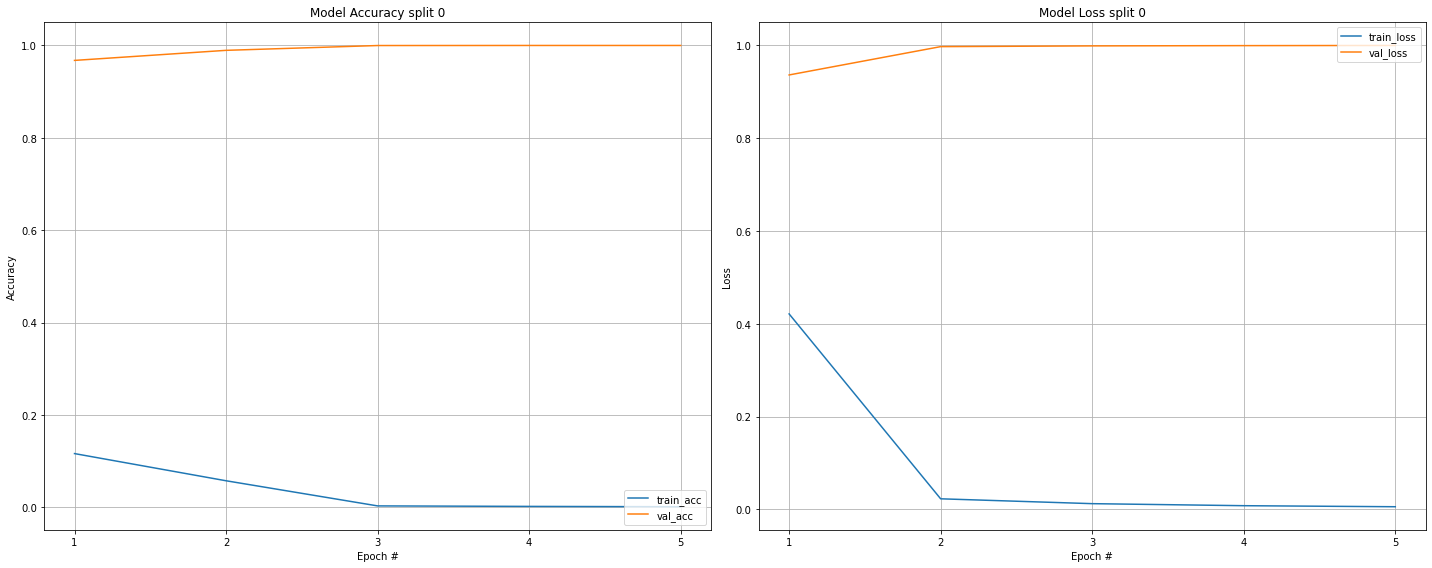

Test Accuracy: 1.00%, Avg loss: 0.001352  


In [6]:
import matplotlib.pyplot as plt
plot_history(hist_train_loss, hist_val_loss, hist_train_acc, hist_val_acc)

test_loss = 0.0
correct = 0
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels =inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(1) == labels).sum().item()

test_acc = correct / len(val_loader.dataset)


print(f"Test Accuracy: {test_acc:.2f}%, Avg loss: {test_loss/len(val_loader):.6f}  ")